# Synthesizing Snowy Tree Cricket Chirps via Direct Digital Synthesis
#### V. Hunter Adams (vha3@cornell.edu)

> - [Introduction](#Introduction)
> - [Decomposing the snowy tree cricket song](#Decomposing-the-snowy-tree-cricket-song)
> > - [Number of syllables](#Number-of-syllables)
> > - [Frequency of a syllable](#Frequency-of-a-syllable)
> > - [Length of a syllable](#Length-of-a-syllable)
> > - [Synthesizing a syllable](#Synthesizing-a-syllable)
> > - [Syllable repeat interval](#Syllable-repeat-interval)
> > - [Synthesizing a chirp](#Synthesizing-a-chirp)
> > - [Chirp repeat interval](#Chirp-repeat-interval)
> > - [Synthesizing a song](#Synthesizing-a-song)
> - [References](#References)

## Before you start
- Please read the [Direct digital synthesis page](https://vanhunteradams.com/DDS/DDS.html) before reading this page

## Introduction

Cricket chirps can be quite complicated. However, an *extremely* convincing simulation can be generated with a rather simple model. In the figure below, which I've copied from Franz Huber and John Thorson's 1935 Scientific American Article [*Cricket Auditory Communication*](./Cricket_auditory_communication.pdf), you can see the mechanical means by which the cricket generates a chirp on the left and a time-domain chirp recording on the top right (*a*). Beneath *a* are a series of temporal patterns that Huber and Thorson synthesized in their experiment. The pattern in *b* captures the features of the natural song, and the other patterns (*c*, *d*, and *e*) modify the pattern in one way or another. Perhaps unsurprisingly, Huber and Thorson found that female crickets respond most reliably to the pattern in *b*. The experiment that they setup to test this is fascinating, and you should read about it in their paper.

We will be synthesizing a variation on the pattern shown in *b*. A cricket chirp will be composed of some number of syllables (the precise number varies from species to species). Each of these syllables is a pure, amplitude-modulated tone of a species-dependent (and, fasinatingly, temperature-dependent) frequency. These syllables are repeated after a brief amount of time (called the "syllable repeat interval"), and then the whole chirp is repeated again after a longer amount time called the "chirp repeat interval." This chirp repeat interval is the amount of time that it takes for the cricket to open its wings to reposition the file and scraper. The degrees of freedom in this song include:

- The number of syllables
- The frequency of a syllable
- The length of a syllable
- The length of the syllable repeat interval
- The length of the chirp repeat interval

As you vary these degrees of freedom, you can produce simulations of different species of cricket. We will focus in particular on the snowy tree cricket.



<figure>
    <img align="center" width="900" height="500" src="cricket.png" alt='missing' />
    <center><figcaption>Figure copied from Huber and Thorson's Scientific American article [1]</figcaption></center>
</figure>

## Decomposing the snowy tree cricket song

Because snowy tree crickets change their song based on temperature, we'll pick a *particular* cricket to emulate. In particular, we'll aim to synthesize the cricket in the video below. We can use an oscilloscope to observe the audio waveform generated by this cricket in order to determine each of the degrees of freedom listed in the introduction section.

<iframe width="560" height="315" src="https://www.youtube.com/embed/9cEU5wjzb4o" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

The synthesized song (constructed incrementally in this document), sound like this:

In [46]:
Audio(song, rate=40000)

#### Number of syllables

The number of syllables is simple enough to determine by observing a single chirp on the oscilloscope. On the scope, we can see that each chirp is composed of 8 syllables.<br><br>

<figure>
    <img align="center" width="900" height="500" src="wholesong.png" alt='missing' />
    <center><figcaption></figcaption></center>
</figure>

#### Frequency of a syllable

We can zoom in on one syllable in particular and use the cursors to measure the frequency. We see that this syllable is a pure tone of approximately 2300 Hz. <br><br>

<figure>
    <img align="center" width="900" height="500" src="frequency.png" alt='missing' />
    <center><figcaption></figcaption></center>
</figure>

#### Length of a syllable

The length of the syllable can also be determined using the cursors. We see that each syllable is approximately 17ms long. If we are generating audio at 40kHz, that corresponds to $\frac{0.017\text{ sec}}{1} \cdot \frac{40000\text{ cycles}}{1\text{ sec}} = 680\text{ cycles}$.

<figure>
    <img align="center" width="900" height="500" src="syllable_length.png" alt='missing' />
    <center><figcaption></figcaption></center>
</figure>

#### Synthesizing a syllable

This is sufficient information to synthesize a single syllable. We will use [Direct Digital Synthesis](https://vanhunteradams.com/DDS/DDS.html) to synthesize a pure tone at 2300Hz, and then we will amplitude modulate that tone so that its volume ramps up and ramps back down, as in the real song.

In [36]:
Fs = 40000 #audio sample rate
sintable = numpy.sin(numpy.linspace(0, 2*numpy.pi, 256))# sine table for DDS
two32 = 2**32 #2^32
DDS_increment = 2300.*two32/Fs #DDS increment

syllable = list(numpy.zeros(680)) # Length of a syllable in audio cycles

DDS_phase = 0 # current phase
for i in range(len(syllable)):
    DDS_phase += DDS_increment # update DDS phase by increment
    DDS_phase = DDS_phase % (two32 - 1) # need to simulate overflow in python, not necessary in C
    syllable[i] = sintable[int(DDS_phase/(2**24))] # can just shift in C
    
# Amplitude modulate with a linear envelope to avoid clicks
amplitudes = list(numpy.ones(len(syllable))) #
amplitudes[0:200] = list(numpy.linspace(0,1,len(amplitudes[0:200]))) # linear ramp up 
amplitudes[-200:] = list(numpy.linspace(0,1,len(amplitudes[-200:]))[::-1]) # linear ramp down
amplitudes = numpy.array(amplitudes) # convert to array

# Finish with the syllable
syllable = syllable*amplitudes

Here is what a syllable looks like:

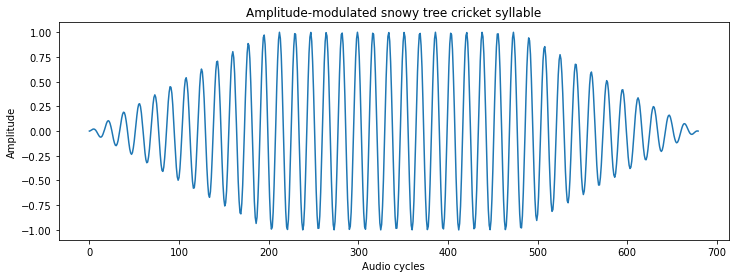

In [37]:
plt.plot(syllable)
plt.xlabel('Audio cycles')
plt.ylabel('Amplitude')
plt.title('Amplitude-modulated snowy tree cricket syllable'); plt.show()

And here is what a syllable sounds like

In [38]:
Audio(syllable, rate=40000)

#### Syllable repeat interval

In order to finish composing a single chirp, we must append 8 syllables together and separate each by the syllable repeat interval. The syllable repeat interval can be measured on the oscilloscope as approximately 2ms, or 80 audio cycles at 40kHz. <br><br>

<figure>
    <img align="center" width="900" height="500" src="syllable_repeat.png" alt='missing' />
    <center><figcaption></figcaption></center>
</figure>

#### Synthesizing a chirp

We now have sufficient information to synthesize a single chirp, which is composed of 8 syllables separated by the syllable repeat interval.

In [39]:
syllable_repeat = numpy.zeros(80)
chirp = []
for i in range(8):
    chirp.extend(syllable)
    chirp.extend(syllable_repeat)

Here is what a chirp looks like:

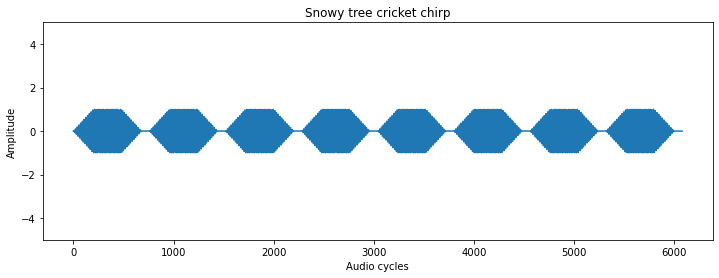

In [40]:
plt.plot(chirp)
plt.xlabel('Audio cycles')
plt.ylabel('Amplitude')
plt.title('Snowy tree cricket chirp')
plt.ylim([-5, 5])
plt.show()

And here is what it sounds like:

In [41]:
Audio(chirp, rate=40000)

#### Chirp repeat interval

Finally, to compose a song, we separate a series of chirps by the chirp repeat interval. As measured on the scope, the chirp repeat interval is approximately 260ms, or 10,400 audio cycles at 40kHz.<br><br>

<figure>
    <img align="center" width="900" height="500" src="chirp_repeat.png" alt='missing' />
    <center><figcaption></figcaption></center>
</figure>

#### Synthesizing a song

To compose a song, we append a series of chirps separated by the chirp repeat interval.

In [42]:
chirp_repeat_interval = numpy.zeros(10400)

In [43]:
song = []
for j in range(100):
    song.extend(chirp)
    song.extend(chirp_repeat_interval)

Here is what the song looks like:

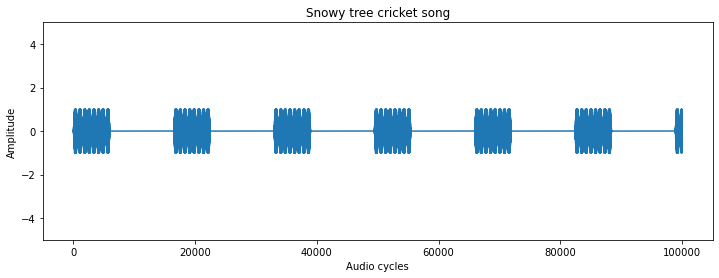

In [44]:
plt.plot(song[0:100000])
plt.xlabel('Audio cycles')
plt.ylabel('Amplitude')
plt.title('Snowy tree cricket song')
plt.ylim([-5, 5])
plt.show()

And here is what it sounds like:

In [45]:
Audio(song, rate=40000)

## References

1. Huber, Franz, and John Thorson. "Cricket auditory communication." Scientific American 253.6 (1985): 60-73.

***

(includes, please ignore)

In [34]:
import numpy
import matplotlib.pyplot as plt
from IPython.display import Audio
from IPython.display import Image
from scipy import signal
from scipy.fft import fftshift
from scipy.io import wavfile
plt.rcParams['figure.figsize'] = [12, 4]
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")